In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import Lasso, ElasticNet, LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from scipy import stats
import matplotlib.pyplot as plt
import math
import seaborn as sns
import re
random_seed = 4057585448 # Random seed for reproducibility.
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_full = pd.concat([df_train, df_test], axis = 0)

First of all, we examine the dataset for missing values. We print out each column to get a feel for the incompleteness of the data.

In [2]:
print('Missing values per column:')
missing = pd.DataFrame()
for c in range(df_full.shape[1]):
    missing_count = df_full.iloc[:, c].shape[0] - df_full.iloc[:, c].count()  
    if missing_count > 0:
        print(f'{c}:\t{df_full.columns[c]}'
              f' - Missing: {missing_count}'
              f' - # Unique values: {len(df_full.iloc[:, c].value_counts())}')

Missing values per column:
3:	Alley - Missing: 2721 - # Unique values: 2
6:	BsmtCond - Missing: 82 - # Unique values: 4
7:	BsmtExposure - Missing: 82 - # Unique values: 4
8:	BsmtFinSF1 - Missing: 1 - # Unique values: 991
9:	BsmtFinSF2 - Missing: 1 - # Unique values: 272
10:	BsmtFinType1 - Missing: 79 - # Unique values: 6
11:	BsmtFinType2 - Missing: 80 - # Unique values: 6
12:	BsmtFullBath - Missing: 2 - # Unique values: 4
13:	BsmtHalfBath - Missing: 2 - # Unique values: 3
14:	BsmtQual - Missing: 81 - # Unique values: 4
15:	BsmtUnfSF - Missing: 1 - # Unique values: 1135
19:	Electrical - Missing: 1 - # Unique values: 5
23:	Exterior1st - Missing: 1 - # Unique values: 15
24:	Exterior2nd - Missing: 1 - # Unique values: 16
25:	Fence - Missing: 2348 - # Unique values: 4
26:	FireplaceQu - Missing: 1420 - # Unique values: 5
30:	Functional - Missing: 2 - # Unique values: 7
31:	GarageArea - Missing: 1 - # Unique values: 603
32:	GarageCars - Missing: 1 - # Unique values: 6
33:	GarageCond - Missing

There exists a lot of missing values. However, reading the data description, it's clear that the data is very clean and that the missing values are real values not incomplete data. We replace all np.nan values with a placeholder below. The placeholder is 'None' for discrete features or zero for continuous features. We also store the names of continuous and discrete features in order to plot them.

We define a continuous feature as any numerical feature with more than 15 unique values. The definition is entirely arbritrary but it serves its function.

In [3]:
missing_label = 'None'
cont_feature = []
disc_feature = []
for c in range(df_full.shape[1]):
    if len(pd.value_counts(df_full.iloc[:, c])) > 15 and df_full.iloc[:, c].values.dtype != 'object':
        if df_full.columns[c] not in ('SalePrice', 'Id'):
            df_full.iloc[:, c].fillna(0, inplace = True)
            cont_feature.append(df_full.columns[c])
    else:
        df_full.iloc[:, c].fillna(missing_label, inplace = True)
        disc_feature.append(df_full.columns[c])

Now we examine our response by plotting its histogram and QQ-plot.

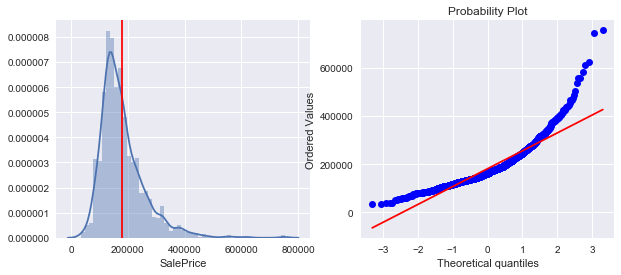

In [4]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
sns.distplot(df_train['SalePrice'], ax = ax[0])
ax[0].axvline(np.mean(df_train['SalePrice']), color = 'red')
stats.probplot(df_train['SalePrice'], plot = ax[1])
plt.show()

We can see from the histogram that our response exhibits positive skewness and positive kurtosis. We attempt to correct for that by applying a square root transformation.

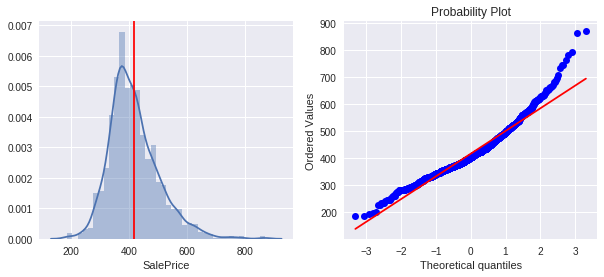

In [7]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
sns.distplot(np.sqrt(df_train['SalePrice']), ax = ax[0])
ax[0].axvline(np.mean(np.sqrt(df_train['SalePrice'])), color = 'red')
stats.probplot(np.sqrt(df_train['SalePrice']), plot = ax[1])
plt.show()

The data still exhibits some skewness and kurtosis. We now instead apply a natural log transformation.

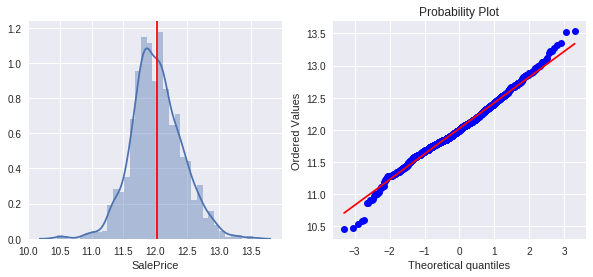

In [8]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (10, 4))
sns.distplot(np.log(df_train['SalePrice']), ax = ax[0])
ax[0].axvline(np.mean(np.log(df_train['SalePrice'])), color = 'red')
stats.probplot(np.log(df_train['SalePrice']), plot = ax[1])
plt.show()

The data is now approximately normal.

In [4]:
df_train['SalePrice'] = np.log(df_train['SalePrice'])
df_full['SalePrice'] = np.log(df_full['SalePrice'])

We then visualize the relation between each continuous feature and the target variable in order to get a better feel for the data.

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


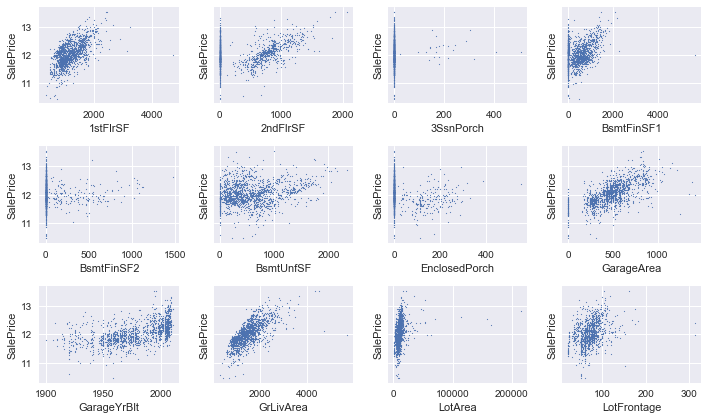

In [5]:
plt.ion()
i = 0
while i < len(cont_feature):
    fig, axs = plt.subplots(nrows = 3,
                            ncols= 4,
                            sharey = 'row', figsize=(10,6))
    axs = axs.flatten()
    for ax in axs:
        if i >= len(cont_feature): break
        ax.scatter(x = df_train[cont_feature[i]],
                   y = df_train['SalePrice'],
                   s = 3, marker = '.')
        ax.set_xlabel(cont_feature[i])
        ax.set_ylabel('SalePrice')
        i += 1
    fig.tight_layout()
    fig.show()

We can see from the graphs that most continuous features can be well approximated by a linear function. Features that represent years can be even better approximated with a linear function after applying a transformation. We do the same for discrete features, plotting them in box plots to get a better feel for the data. We also convert the labels to numeric ordinal values. In addition, we move the MSSubClass feature to the discrete columns to sort it into ordinal values.

C:\Anaconda3\lib\site-packages\matplotlib\figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


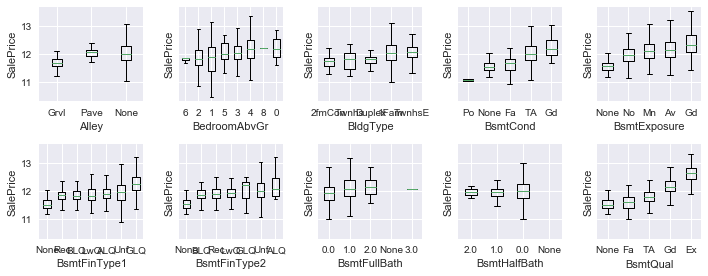

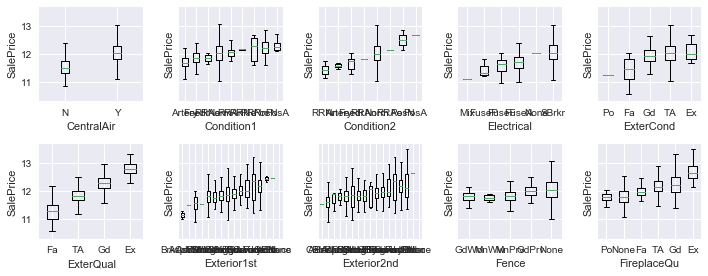

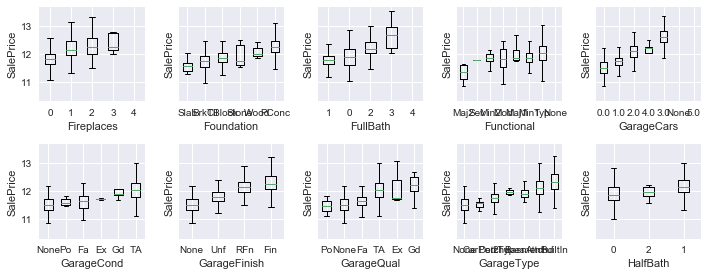

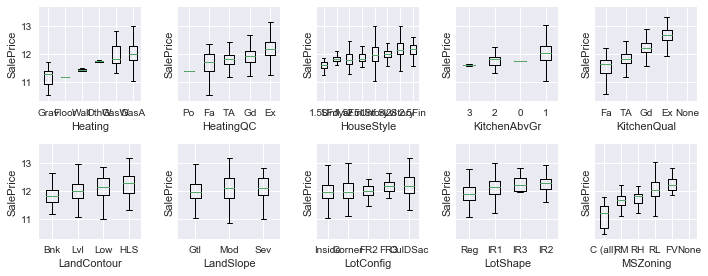

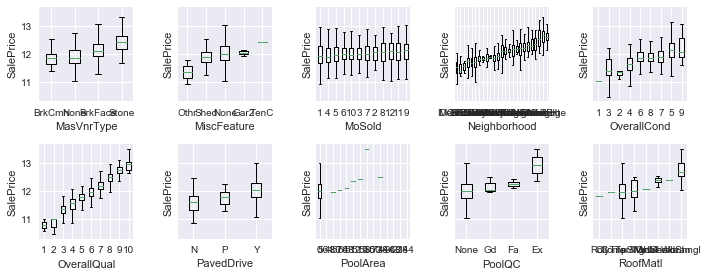

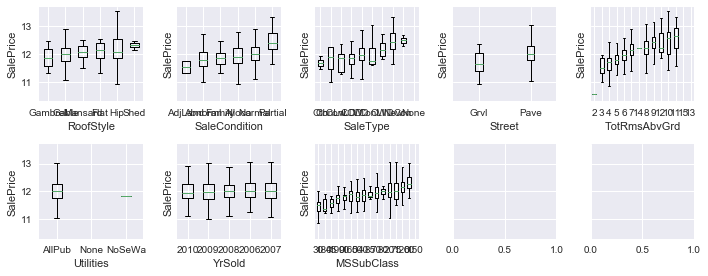

In [6]:
cont_feature.remove('MSSubClass')
disc_feature.append('MSSubClass')
i = 0
while i < len(disc_feature):
    fig, axs = plt.subplots(nrows = 2,
                            ncols= 5,
                            sharey = 'row',
                            figsize = (10, 4))
    axs = axs.flatten()
    for ax in axs:
        if i >= len(disc_feature): break
        categories = df_full[disc_feature[i]].value_counts().index.tolist()
        categories.sort(key = lambda x: df_full['SalePrice'][df_full[disc_feature[i]] == x].mean())
        t = df_full.iloc[:df_train.shape[0], :]
        boxes = [t['SalePrice'][t[disc_feature[i]] == category] for category in categories]
        ax.boxplot(boxes, labels=categories)
        ax.set_xlabel(disc_feature[i])
        ax.set_ylabel('SalePrice')
        
        # Transforming labels into ordinal values sorted according to mean (from above).
        categories = dict(zip(categories, range(len(categories))))
        df_full[disc_feature[i]] = df_full[disc_feature[i]].apply(lambda x: categories[x])
        i += 1
        
    fig.tight_layout()
    fig.show()
plt.show()

Once again, it appears that most features can be modelled with a linear function. We can conclude that a linear model will do well on this data, but we'll try different methods as well just to be sure. We standardize the data and prepare to initially model it without reducing its dimensionality to see how well it will do in its 'default' state.

In [7]:
df_train = df_full.iloc[:df_train.shape[0], :]
df_test = df_full.iloc[df_train.shape[0]:, :]

X_train = df_train.copy()[[x for x in df_train.columns if x not in ('SalePrice', 'Id')]].values
y_train = df_train.copy()['SalePrice'].values
X_test = df_test.copy()[[x for x in df_test.columns if x not in ('SalePrice', 'Id')]].values

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

We then test our default model and fit it with a Random Forest. Also, to get a reference for how well our model is doing, we calculate the train error we get if we simply predict the mean for each value in target variable. 

In [8]:
print('Default error:', math.sqrt(mean_squared_error(y_train, np.mean(y_train) * np.ones(y_train.shape))))

print("Grid searching RF model... ")
rf_gs = GridSearchCV(cv=5, n_jobs=-1, scoring="neg_mean_squared_error", verbose=0,
                      estimator=RandomForestRegressor(n_estimators = 100,
                                                       max_features='sqrt',
                                                       min_samples_split=5,
                                                       random_state=random_seed),
                      param_grid=[{'max_depth': [x for x in range(2, 50)]}])
rf_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-rf_gs.best_score_)}')
print(rf_gs.best_params_)

Default error: 0.39931504624370256
Grid searching RF model... 


Best score is 0.13902371407979378
{'max_depth': 18}


Not bad, but we can do better.

We now attempt to get better predictions. We start by trying to get rid of variables which do not show high variability. We do this by first stardardizing all features then calculating and examining each feature's kurtosis.

In [9]:
df_train_std = pd.DataFrame(sc.fit_transform(df_train))
print("Kurtosis for each feature: ")
kurts = [(c, df_train.columns[c], stats.kurtosis(df_train.iloc[:, c])) for c in range(df_train.shape[1])]
kurts.sort(key = lambda x: x[2], reverse = True)
for s in kurts:
    print(f'{s[0]}:\t{s[1]}: {s[2]}')

Kurtosis for each feature: 
76:	Utilities: 1455.0006854009598
58:	MiscVal: 698.6008400387273
66:	PoolQC: 337.21839013332107
65:	PoolArea: 334.1782893575687
73:	Street: 238.3374598807885
48:	LotArea: 202.5437927513529
18:	Condition2: 145.55460665409737
2:	3SsnPorch: 123.23517727268867
67:	RoofMatl: 117.18069371062833
40:	Heating: 109.53882082586568
52:	LowQualFinSF: 82.945932358931
57:	MiscFeature: 32.69496584908665
47:	LandSlope: 24.50934105741593
30:	Functional: 22.089776776637194
9:	BsmtFinSF2: 20.04041549471293
72:	ScreenPorch: 18.371874098863685
44:	KitchenAbvGr: 17.64442035330982
13:	BsmtHalfBath: 16.336436104708067
3:	Alley: 16.307788924109296
75:	TotalBsmtSF: 13.201041630635025
37:	GarageYrBlt: 12.99449313206571
6:	BsmtCond: 12.85524519519693
8:	BsmtFinSF1: 11.076089857631942
46:	LandContour: 10.872631252502494
19:	Electrical: 10.779273032368714
16:	CentralAir: 10.43801812222865
20:	EnclosedPorch: 10.39097160371135
55:	MasVnrArea: 10.102611811101848
17:	Condition1: 9.97669302173

We discard any feature with a kurtosis value which is greater than positive 15 (indicating low variability within the feature itself). We use kurtosis instead of variance since all the variables are standardized, so by definition they'll have a variance of exactly 1.0.

In [10]:
df_full = df_full.drop([s[1] for s in kurts if s[2] > 15 and s[1] != 'SalePrice'], axis = 1)
print(df_full.shape)

(2919, 62)


We one hot encode categorical features and standardize the data.

In [11]:
cat_variables = ['LandContour',
                 'LotConfig',
                 'Neighborhood',
                 'Condition1',
                 'Condition2',
                 'RoofStyle',
                 'Exterior1st',
                 'Exterior2nd',
                 'Heating',
                 'GarageType',
                 'MiscFeature',
                 'SaleType',
                 'SaleCondition']

for c in cat_variables:
    if c in cont_feature:
        cont_feature.remove(c)
        
cols = ['SalePrice']
df_cstd_train = df_full[['SalePrice']].iloc[:df_train.shape[0],:]
df_cstd_test = pd.DataFrame()

df_train = df_full.iloc[:df_train.shape[0], :].copy()
df_test = df_full.iloc[df_train.shape[0]:, :].copy()

sc = StandardScaler()
for c in cont_feature.copy():
    if c not in df_full.columns:
        cont_feature.remove(c)
        continue
    c_train = sc.fit_transform(df_train[c].values.reshape(-1,1))
    c_test = sc.transform(df_test[c].values.reshape(-1,1))
    df_cstd_train = pd.concat([df_cstd_train, pd.DataFrame(c_train)], axis = 1)
    df_cstd_test = pd.concat([df_cstd_test, pd.DataFrame(c_test)], axis = 1)
    cols.append(c)
    
ohe = OneHotEncoder(sparse = False)
for c in cat_variables.copy():
    if c not in df_full.columns:
        cat_variables.remove(c)
        continue
    c_cat_full = ohe.fit_transform(df_full[c].values.reshape(-1, 1))
    df_cstd_train = pd.concat([df_cstd_train, pd.DataFrame(c_cat_full[:df_train.shape[0],:])], axis = 1)
    df_cstd_test = pd.concat([df_cstd_test, pd.DataFrame(c_cat_full[df_train.shape[0]:,:])], axis = 1)
    for j in range(len(np.unique(df_full[c]))):
        cols.append(c+str(j+1))
        cat_variables.append(c+str(j+1))
        
for c in df_full.columns:
    if c not in cont_feature and c not in cat_variables and c != 'SalePrice':
        df_cstd_train = pd.concat([df_cstd_train, df_train[c]], axis = 1)
        df_cstd_test = pd.concat([df_cstd_test, df_test[c]], axis = 1)
        cols.append(c)

df_cstd_train.columns = cols
df_cstd_test.columns = cols[1:]
df_train = pd.DataFrame(sc.fit_transform(df_cstd_train.iloc[:,1:]), columns = cols[1:])
df_test = pd.DataFrame(sc.transform(df_cstd_test), columns = cols[1:])
df_train = pd.concat([df_cstd_train['SalePrice'], df_train], axis = 1)

C:\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


Then we get rid of outliers in our data. We define an outlier as an observation with a Z-score greater than 4.0 in any column.

In [10]:
drop_indices = []
for i in range(df_train.shape[0]):
    for j in cont_feature:
        if math.fabs(df_train[j].iloc[i]) > 4.0:
            drop_indices.append(i)
            break
df_train.drop(drop_indices, axis = 0, inplace = True)
#print(len(drop_indices))
print(df_train.shape)

(1331, 157)




<p>Let's try to reduce our data's dimensionality. First, we plot a PCA scree plot to see how well we can do by simply projecting our data to a lower dimension.</p>

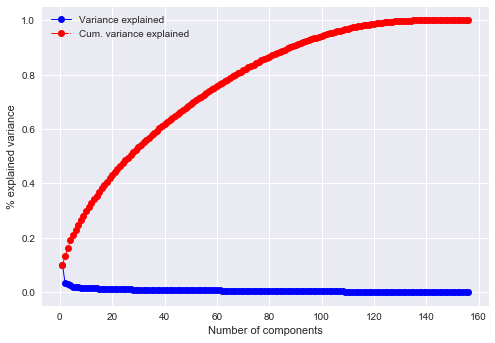

In [13]:
X_train = df_train[[x for x in df_train.columns if x != 'SalePrice']].values
X_train = sc.fit_transform(X_train)
pca = PCA(random_state = random_seed)
pca.fit(X_train)

plt.plot(range(1, X_train.shape[1] + 1),
         pca.explained_variance_ratio_,
         lw=1, color='blue',
         label='Variance explained',
         marker = 'o')
plt.plot(range(1, X_train.shape[1] + 1),
         np.cumsum(pca.explained_variance_ratio_),
         lw=1, color='red',
         ls='-.', marker = 'o',
         label='Cum. variance explained')
plt.xlabel('Number of components')
plt.ylabel('% explained variance')
plt.legend(loc = 'upper left')
plt.show()

<p>Due to the smoothness of the scree plot, we cannot use PCA to reduce our data's dimensionality.</p>

We display a heatmap to visualize the correlation between each feature.

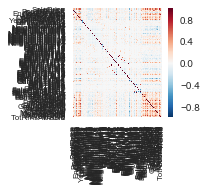

(52, 52)


In [13]:
sns.plt.subplots(figsize=(2,2))
g = sns.heatmap(df_train.corr('pearson'))
g.set_yticklabels(g.get_yticklabels(), rotation=0, fontsize=8)
g.set_xticklabels(g.get_xticklabels(), rotation=90, fontsize=8)
sns.plt.show()
print(df_train[[x for x in df_train.columns if x not in cat_variables]].corr('pearson').shape)

Then for each pair of features with a correlation of 0.75 or greater, we get rid of one of them.

In [11]:
drop_feat = set()
corr_matrix = df_train.corr('pearson')
for i in range(1, corr_matrix.shape[0]):
    for j in range(i+1, corr_matrix.shape[1]):
        if math.fabs(corr_matrix.iloc[i, j]) > 0.75 and df_train.columns[j] != 'SalePrice':
            drop_feat.add(df_train.columns[j])
print(len(drop_feat))
df_train.drop(drop_feat, axis = 1, inplace = True)
df_test.drop(drop_feat, axis = 1, inplace = True)

19


Here, we get rid of any feature with only one unique value (they provide no information about the response).

In [12]:
drop_feat.clear()
for j in df_train.columns:
    if len(df_train[j].unique()) == 1:
        drop_feat.add(j)
df_train.drop(drop_feat, axis = 1, inplace = True)
df_test.drop(drop_feat, axis = 1, inplace = True)
print(df_train.shape)

(1331, 134)


We then compute the correlation between the target feature and every other feature to study the importance of each feature in predicting the response.

In [13]:
corr = [(df_train.columns[c], df_train['SalePrice'].corr(df_train.iloc[:, c])) for c in range(df_train.shape[1])]
corr.sort(key = lambda x: x[1], reverse = True)
for c in corr:
    print(c)

('SalePrice', 1.0)
('OverallQual', 0.81227618500954202)
('GrLivArea', 0.71195237208522322)
('ExterQual', 0.67638379970697782)
('KitchenQual', 0.66725416914854774)
('BsmtQual', 0.65523303500061403)
('GarageArea', 0.61867523521294254)
('1stFlrSF', 0.59502332163926419)
('FullBath', 0.59323777180441417)
('YearRemodAdd', 0.58024441034999941)
('GarageYrBlt', 0.55959985938040402)
('Foundation', 0.5553474413137921)
('GarageFinish', 0.5548292511421038)
('MSSubClass', 0.53199519525743921)
('FireplaceQu', 0.52713006352296865)
('HeatingQC', 0.47265944505162533)
('MasVnrType', 0.43133133546198232)
('MasVnrArea', 0.42666550606178089)
('MSZoning', 0.41083429355368084)
('BsmtFinType1', 0.40725626792477293)
('OpenPorchSF', 0.39551484000073323)
('OverallCond', 0.38512109203196959)
('BsmtFinSF1', 0.37283717423617124)
('Exterior1st13', 0.36615248922397442)
('BsmtExposure', 0.36148489843937354)
('Neighborhood24', 0.35671532882156115)
('WoodDeckSF', 0.3270022064602231)
('CentralAir', 0.31781346665950738)
('

We drop every feature that has an absolute correlation of less the 0.1 with that response.

In [14]:
df_train = df_train.drop([c[0] for c in corr if math.fabs(c[1]) < 0.1], axis = 1)
df_test = df_test.drop([c[0] for c in corr if math.fabs(c[1]) < 0.1], axis = 1)

In [15]:
print(df_train.shape)

(1331, 78)


Finally, we search for the best model that represents our data.

In [16]:
X_train = df_train.copy()[[x for x in df_train.columns if x not in ('SalePrice', 'Id')]].values
y_train = df_train.copy()['SalePrice'].values
X_test = df_test.copy()[[x for x in df_test.columns if x not in ('SalePrice', 'Id')]].values

In [17]:
print("Grid searching GB model...")
gb_gs = GridSearchCV(cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=GradientBoostingRegressor(random_state = random_seed),
                      param_grid=[{'learning_rate': [x / 100 for x in range(5, 20, 1)],
                                   'max_depth': [x for x in range(2, 7)],
                                   'max_features': [x / 10 for x in range(1, 11)]}])
gb_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-gb_gs.best_score_)}')
print(gb_gs.best_params_)
print()

'''
print("Grid searching AB model...")
ad_gs = GridSearchCV(cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=AdaBoostRegressor(base_estimator=LinearRegression(),
                                                  random_state=random_seed),
                      param_grid=[{'learning_rate': [x / 100 for x in range(85, 115, 1)]}])
ad_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-ad_gs.best_score_)}')
print(ad_gs.best_params_)
print()
'''
print("Grid searching bagging model...")
bag_gs = GridSearchCV(cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=BaggingRegressor(base_estimator = LinearRegression(),
                                                 n_estimators = 25),
                      param_grid=[{'max_features': [x / 100 for x in range(50, 101, 1)]}])
bag_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-bag_gs.best_score_)}')
print(bag_gs.best_params_)
print()

print("Grid searching RF model... ")
rf_gs = GridSearchCV(cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=RandomForestRegressor(n_estimators = 100,
                                                       max_features='sqrt',
                                                       min_samples_split=5,
                                                       random_state=random_seed),
                      param_grid=[{'max_depth': [x for x in range(2, 50)]}])
rf_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-rf_gs.best_score_)}')
print(rf_gs.best_params_)

print("Grid searching lasso model...")
lasso_gs = GridSearchCV(cv=5, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=Lasso(max_iter = 10**5),
                      param_grid=[{'alpha': [x / 10000 for x in range(10, 1000, 1)]}])
lasso_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-lasso_gs.best_score_)}')
print(lasso_gs.best_params_)
print()

print("Grid searching ridge model...")
ridge_gs = GridSearchCV(cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=Ridge(max_iter = 10**5),
                      param_grid=[{'alpha': [x / 10 for x in range(0, 150, 2)]}])
ridge_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-ridge_gs.best_score_)}')
print(ridge_gs.best_params_)
print()

import os
#os.system('rundll32.exe PowrProf.dll,SetSuspendState 0,1,0')

Grid searching GB model...


Best score is 0.11801003546164311
{'learning_rate': 0.08, 'max_depth': 4, 'max_features': 0.3}

Grid searching bagging model...


Best score is 0.11675292219114232
{'max_features': 0.65}

Grid searching RF model... 


Best score is 0.13130901489182387
{'max_depth': 14}
Grid searching lasso model...


Best score is 0.1179223867616268
{'alpha': 0.0016}

Grid searching ridge model...


Best score is 0.11739023439822041
{'alpha': 14.8}



We search further around the best parameters to get an even better model.

In [18]:
print("Grid searching lasso model...")
lasso_gs = GridSearchCV(cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=Lasso(max_iter = 10**5),
                      param_grid=[{'alpha': [x / 10000 for x in range(10, 2000, 1)]}])
lasso_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-lasso_gs.best_score_)}')
print(lasso_gs.best_params_)
print()

print("Grid searching ridge model...")
ridge_gs = GridSearchCV(cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=Ridge(max_iter = 10**5),
                      param_grid=[{'alpha': [x / 100 for x in range(1300, 1500, 2)]}])
ridge_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-ridge_gs.best_score_)}')
print(ridge_gs.best_params_)
print()

print("Grid searching GB model...")
gb_gs = GridSearchCV(cv=10, n_jobs=-1, scoring='neg_mean_squared_error', verbose=0,
                      estimator=GradientBoostingRegressor(random_state = random_seed),
                      param_grid=[{'learning_rate': [x/1000 for x in range(170, 190, 1)],
                                   'max_features': [x / 100 for x in range(25, 35)],
                                   'max_depth': [4]}])
gb_gs.fit(X_train, y_train)
print(f'Best score is {math.sqrt(-gb_gs.best_score_)}')
print(gb_gs.best_params_)
print()

Grid searching lasso model...


Best score is 0.11684544283072915
{'alpha': 0.0015}

Grid searching ridge model...


Best score is 0.11738786653825016
{'alpha': 14.98}

Grid searching GB model...


Best score is 0.11777720351667989
{'learning_rate': 0.172, 'max_depth': 4, 'max_features': 0.32}



So now that we know our optimal hyperparameters, we train the model on the full dataset, predict the target using the test data, and output them to a .csv file.

In [19]:
best = lasso_gs.best_estimator_
best.fit(X_train, y_train)
y_pred = np.exp(best.predict(X_test))
output = pd.concat([pd.read_csv('test.csv')['Id'], pd.Series(y_pred)], axis = 1)
output.columns = ['Id', 'SalePrice']
output.to_csv('submissions.csv', index = False)